# Модель для соотношения матрица-наполнитель

Постановка задачи:
    Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 


In [130]:
# Импортирую необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyRegressor
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

from sklearn import metrics
import pickle

# Импорт библиотеки TensorFlow
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.11.0


In [43]:
import warnings
warnings.filterwarnings("ignore")

In [288]:
#Загрузим уже подготовленный датасет

df = pd.read_excel('composites.xlsx', index_col=0)
df.tail()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
1018,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669,90,9.076380,47.019770
1019,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099,90,10.565614,53.750790
1020,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764,90,4.161154,67.629684
1021,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,2071.715856,197.126067,90,6.313201,58.261074
1022,3.808020,1890.413468,417.316232,129.183416,27.474763,300.952708,758.747882,74.309704,2856.328932,194.754342,90,6.078902,77.434468


In [289]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1022
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1000 non-null   float64
 1   Плотность, кг/м3                      1000 non-null   float64
 2   модуль упругости, ГПа                 1000 non-null   float64
 3   Количество отвердителя, м.%           1000 non-null   float64
 4   Содержание эпоксидных групп,%_2       1000 non-null   float64
 5   Температура вспышки, С_2              1000 non-null   float64
 6   Поверхностная плотность, г/м2         1000 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1000 non-null   float64
 8   Прочность при растяжении, МПа         1000 non-null   float64
 9   Потребление смолы, г/м2               1000 non-null   float64
 10  Угол нашивки, град                    1000 non-null   int64  
 11  Шаг нашивки      

#### Проведем препроцессинг данных

In [290]:
X = df.copy()
y = X.pop('Соотношение матрица-наполнитель')
X.tail()

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
1018,1952.087902,912.855545,86.992183,20.123249,324.774576,209.198700,73.090961,2387.292495,125.007669,90,9.076380,47.019770
1019,2050.089171,444.732634,145.981978,19.599769,254.215401,350.660830,72.920827,2360.392784,117.730099,90,10.565614,53.750790
1020,1972.372865,416.836524,110.533477,23.957502,248.423047,740.142791,74.734344,2662.906040,236.606764,90,4.161154,67.629684
1021,2066.799773,741.475517,141.397963,19.246945,275.779840,641.468152,74.042708,2071.715856,197.126067,90,6.313201,58.261074
1022,1890.413468,417.316232,129.183416,27.474763,300.952708,758.747882,74.309704,2856.328932,194.754342,90,6.078902,77.434468


In [291]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[0.60138107, 0.44706097, 0.12304725, ..., 0.        , 0.27510888,
        0.54465195],
       [0.60138107, 0.44706097, 0.60802059, ..., 0.        , 0.34453943,
        0.36507374],
       [0.60138107, 0.45572116, 0.5027998 , ..., 0.        , 0.34453943,
        0.50321082],
       ...,
       [0.46022685, 0.25161199, 0.4946564 , ..., 1.        , 0.28629789,
        0.65004618],
       [0.69151992, 0.44872381, 0.68413049, ..., 1.        , 0.43571567,
        0.52063093],
       [0.2594722 , 0.25190326, 0.60914657, ..., 1.        , 0.41944815,
        0.7854866 ]])

In [292]:
# Разделяем на тренировочную и тестовую выборку

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train:', X_train_raw.shape, 'y_train:', y_train.shape)
print('X_test:', X_test_raw.shape, 'y_test:', y_test.shape)

X_train: (700, 12) y_train: (700,)
X_test: (300, 12) y_test: (300,)


In [293]:
X_test[3]

array([0.57936991, 0.42015954, 0.74271258, 0.97824981, 0.5676903 ,
       0.61364378, 0.75734292, 0.20623149, 0.09555904, 1.        ,
       0.78246029, 0.32154   ])

In [294]:
X_test_df = pd.DataFrame(X_test)

In [295]:
X_test_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.485457,0.447092,0.465815,0.504972,0.482564,0.368010,0.499138,0.498264,0.521920,0.496667,0.496119,0.502935
std,0.176594,0.201199,0.171045,0.188790,0.171076,0.215103,0.169168,0.167497,0.175864,0.500824,0.177293,0.157508
min,0.003805,0.011740,-0.023036,0.088844,-0.002129,-0.000827,0.109917,-0.012338,0.036144,0.000000,0.007674,0.045952
25%,0.361222,0.316762,0.364527,0.368022,0.377817,0.206174,0.389974,0.381692,0.415041,0.000000,0.357166,0.411923
50%,0.495888,0.453015,0.466582,0.502579,0.481722,0.339492,0.483302,0.500463,0.525088,0.000000,0.495715,0.510513
75%,0.581373,0.584354,0.584382,0.645745,0.603799,0.541643,0.601782,0.601295,0.639266,1.000000,0.613393,0.606948
max,0.998919,0.986997,0.996752,1.003605,0.914165,1.002058,1.024443,0.972893,0.919471,1.000000,1.029103,0.899125


DummyRegressor, возвращающая среднее, для оценки качества модели.

In [296]:
# Базовая модель

base_model = DummyRegressor(strategy='mean')

# Предсказание базовой модели

base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

#### MLPRegressor из библиотеки sklearn.

In [297]:
from sklearn.neural_network import MLPRegressor

In [298]:
# Настраиваем нейросеть
model = MLPRegressor(
    hidden_layer_sizes = (24, 24),
    activation = 'relu',
    solver='adam',
    max_iter=5000,
    early_stopping = True,
    random_state=42, 
    verbose=True
)

In [299]:
%%time
# Запускаем нейросеть

model.fit(X_train, y_train)

Iteration 1, loss = 6.67508596
Validation score: -12.790193
Iteration 2, loss = 6.39996522
Validation score: -12.231531
Iteration 3, loss = 6.13532143
Validation score: -11.695342
Iteration 4, loss = 5.87245871
Validation score: -11.163439
Iteration 5, loss = 5.61282330
Validation score: -10.602602
Iteration 6, loss = 5.33743664
Validation score: -10.004988
Iteration 7, loss = 5.04331394
Validation score: -9.372883
Iteration 8, loss = 4.72047697
Validation score: -8.683955
Iteration 9, loss = 4.36604698
Validation score: -7.901107
Iteration 10, loss = 3.97563367
Validation score: -7.038874
Iteration 11, loss = 3.55655972
Validation score: -6.130189
Iteration 12, loss = 3.11808774
Validation score: -5.194837
Iteration 13, loss = 2.66845911
Validation score: -4.237027
Iteration 14, loss = 2.22392769
Validation score: -3.300617
Iteration 15, loss = 1.79627972
Validation score: -2.429846
Iteration 16, loss = 1.40553898
Validation score: -1.667678
Iteration 17, loss = 1.07136306
Validation 

MLPRegressor(early_stopping=True, hidden_layer_sizes=(24, 24), max_iter=5000,
             random_state=42, verbose=True)

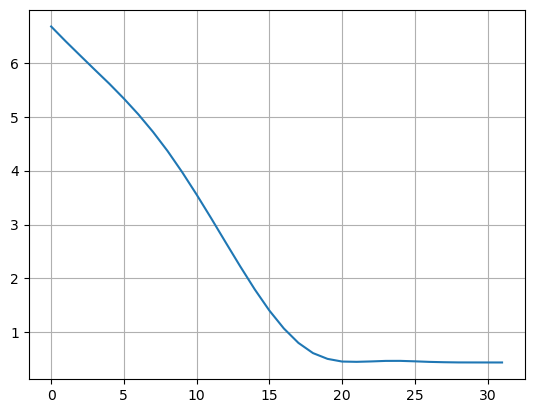

In [300]:
# График ошибки

plt.plot(model.loss_curve_)
plt.grid(True)
plt.show()

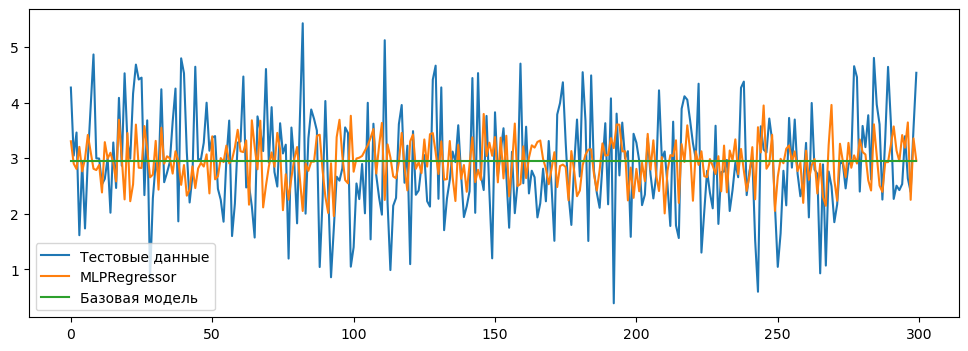

In [301]:
# Предсказание нейросети
y_pred_skl = model.predict(X_test)

# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test.values, label='Тестовые данные')
ax.plot(y_pred_skl, label='MLPRegressor')
ax.plot(y_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [302]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred, squared=False) * -1
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred) * -1
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred) * -1
    return stat

In [303]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare = get_metrics('DummyRegressor', y_test, y_pred_base)
compare = compare.append(get_metrics('MLPRegressor', y_test, y_pred_skl))
compare

,R2,RMSE,MAE,max_error
DummyRegressor,-0.000744,-0.924041,-0.739327,-2.554458
MLPRegressor,-0.175059,-1.001289,-0.786410,-3.375862


Нейросеть, построенная с помощью MLPRegressor, возвращает данные, похожие на исходные. Ошибка по всем метрикам значительно хуже, чем у базовой модели. Возможно, ошибку можно уменьшить, экспериментируя со структурой нейросети.

#### Построим нейронную сеть с помощью библиотеки TensorFlow

In [304]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(12,), name='in'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, name='out')])


In [305]:
model_tf.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])


In [306]:
model_tf.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 8)                 104       
                                                                 
 dense_27 (Dense)            (None, 8)                 72        
                                                                 
 out (Dense)                 (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [307]:
# Функция для построения графика ошибки

def model_loss_plot(model_history):
    plt.figure(figsize=(10, 5))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('График потерь модели', size=12)
    plt.ylabel('Средняя абсолютная ошибка', size=12)
    plt.xlabel('Эпоха', size=12)
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()

In [308]:
%%time
#Обучение нейросети

history = model_tf.fit(
  X_train, 
  y_train, 
  epochs=50, 
  validation_split=0.3, 
  verbose=1
)

Epoch 1/50
16/16 [==============================] - 2s 17ms/step - loss: 7.0520 - mae: 2.5084 - val_loss: 7.0722 - val_mae: 2.4817
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 5.7532 - mae: 2.2323 - val_loss: 5.6462 - val_mae: 2.1754
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 4.4195 - mae: 1.9111 - val_loss: 4.2032 - val_mae: 1.8139
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 3.1118 - mae: 1.5442 - val_loss: 2.8860 - val_mae: 1.4332
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 1.9841 - mae: 1.1765 - val_loss: 1.8789 - val_mae: 1.1097
Epoch 6/50
16/16 [==============================] - 0s 7ms/step - loss: 1.2502 - mae: 0.9135 - val_loss: 1.2834 - val_mae: 0.9085
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 0.9199 - mae: 0.7771 - val_loss: 1.0686 - val_mae: 0.8373
Epoch 8/50
16/16 [==============================] - 0s 7ms/step - loss: 0.8317 - mae: 0.7

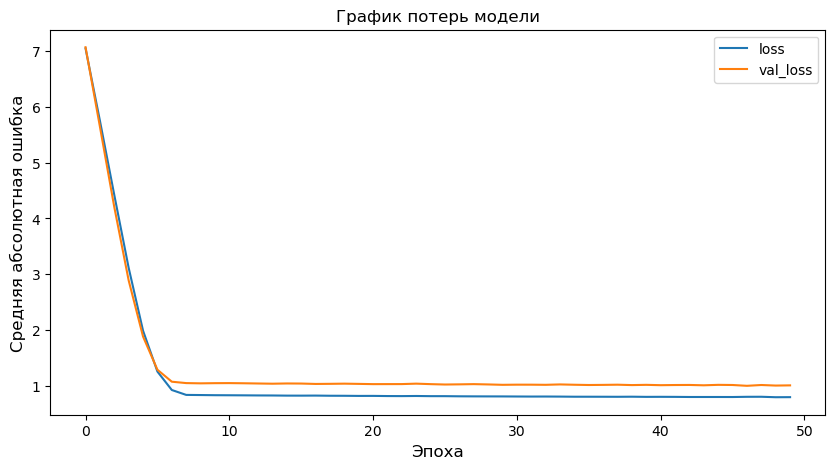

In [309]:
model_loss_plot(history)

In [310]:
# Проверяем точность нейросети на тестовых данных

model_tf.evaluate(X_test, y_test)

10/10 [==============================] - 0s 4ms/step - loss: 0.9413 - mae: 0.7697


[0.9412727952003479, 0.7696837186813354]

In [311]:
# Предсказание 

y_pred_tf = model_tf.predict(X_test)

10/10 [==============================] - 0s 3ms/step


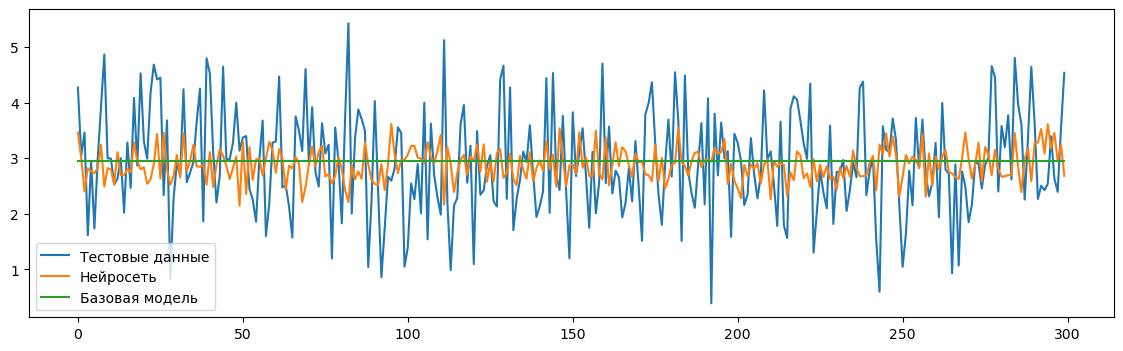

In [312]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_test.values, label='Тестовые данные')
ax.plot(y_pred_tf, label='Нейросеть')
ax.plot(y_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Попробуем сократить количество эпох, на графике видно что примерно начиная с 8й эпохи, ошибка не уменьшается

In [313]:
model_tf_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(12,), name='in'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, name='out')])

model_tf_2.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])

In [314]:
%%time
#Обучение нейросети

history_2 = model_tf_2.fit(
  X_train, 
  y_train, 
  epochs=12, 
  validation_split=0.3, 
  verbose=1,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/12
16/16 [==============================] - 1s 18ms/step - loss: 9.1140 - mae: 2.8694 - val_loss: 8.1355 - val_mae: 2.6691
Epoch 2/12
16/16 [==============================] - 0s 6ms/step - loss: 6.4665 - mae: 2.3625 - val_loss: 5.8392 - val_mae: 2.1988
Epoch 3/12
16/16 [==============================] - 0s 7ms/step - loss: 4.6215 - mae: 1.9409 - val_loss: 4.1777 - val_mae: 1.7918
Epoch 4/12
16/16 [==============================] - 0s 7ms/step - loss: 3.2244 - mae: 1.5626 - val_loss: 2.9315 - val_mae: 1.4431
Epoch 5/12
16/16 [==============================] - 0s 7ms/step - loss: 2.2217 - mae: 1.2579 - val_loss: 2.0695 - val_mae: 1.1585
Epoch 6/12
16/16 [==============================] - 0s 7ms/step - loss: 1.5893 - mae: 1.0400 - val_loss: 1.5514 - val_mae: 0.9835
Epoch 7/12
16/16 [==============================] - 0s 7ms/step - loss: 1.2358 - mae: 0.9055 - val_loss: 1.2984 - val_mae: 0.8973
Epoch 8/12
16/16 [==============================] - 0s 7ms/step - loss: 1.0884 - mae: 0.8

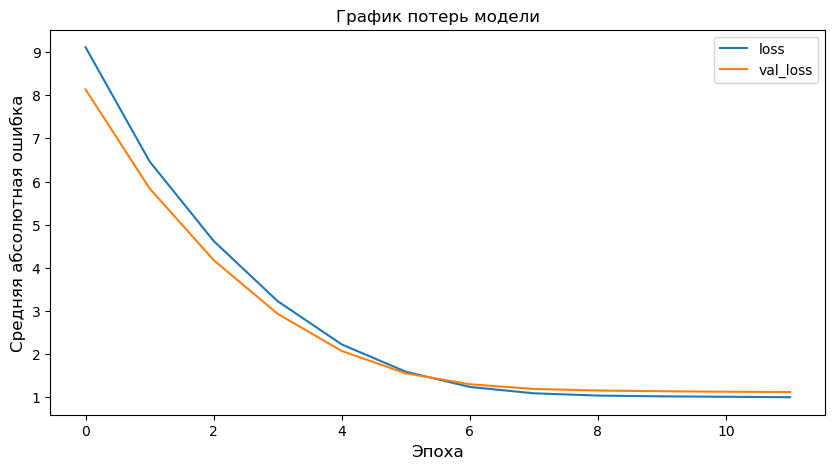

In [315]:
model_loss_plot(history_2)

In [316]:
#Проверяем точность нейросети на тестовых данных

model_tf_2.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 1.1128 - mae: 0.8515


[1.1128482818603516, 0.8515368700027466]

In [317]:
# Предсказание 

y_pred_tf_2 = model_tf_2.predict(X_test)

10/10 [==============================] - 0s 2ms/step


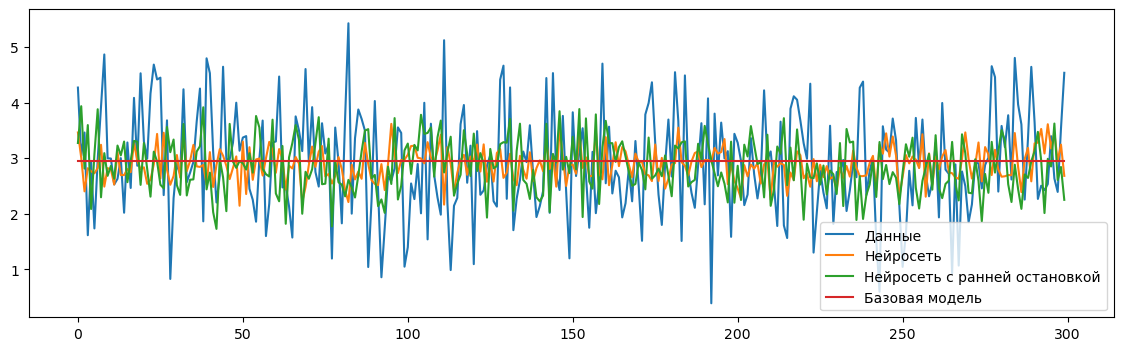

In [318]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_test.values, label='Данные')
ax.plot(y_pred_tf, label='Нейросеть')
ax.plot(y_pred_tf_2, label='Нейросеть c ранней остановкой')
ax.plot(y_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [319]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare = compare.append(get_metrics('Нейросеть TF', y_test, y_pred_tf))
compare = compare.append(get_metrics('Нейросеть TF с ранней остановкой', y_test, y_pred_tf_2))
compare

,R2,RMSE,MAE,max_error
DummyRegressor,-0.000744,-0.924041,-0.739327,-2.554458
MLPRegressor,-0.175059,-1.001289,-0.786410,-3.375862
Нейросеть TF,-0.103204,-0.970192,-0.769684,-3.215724
Нейросеть TF с ранней остановкой,-0.304296,-1.054916,-0.851537,-2.816298


Сохраним параметры модели для веб-приложения

In [320]:
models_path = 'app/models/'

In [321]:
def save_object_with_pickle(obj, obj_name):
  filename = models_path + obj_name
  file = open(filename, 'wb')
  pickle.dump(obj, file)
  file.close()

    
def load_object_with_pickle(obj_name):
  filename = models_path + obj_name
  file = open(filename, 'rb')
  obj = pickle.load(file)
  file.close()
  return obj

In [322]:
save_object_with_pickle(scaler, 'scaler.pkl')

In [323]:
model_tf.save(models_path)

INFO:tensorflow:Assets written to: app/models/assets


INFO:tensorflow:Assets written to: app/models/assets


#### Проверим, как загружаются наши модели

In [324]:
s = keras.models.load_model('C:/Users/sumbu/Downloads/Data/ВКР/Moe/app/models')

In [325]:
s

In [326]:
#Обученный scaler

print(scaler.__dict__)

{'feature_range': (0, 1), 'copy': True, 'clip': False, 'feature_names_in_': array(['Плотность, кг/м3', 'модуль упругости, ГПа',
       'Количество отвердителя, м.%', 'Содержание эпоксидных групп,%_2',
       'Температура вспышки, С_2', 'Поверхностная плотность, г/м2',
       'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype=object), 'n_features_in_': 12, 'n_samples_seen_': 1000, 'scale_': array([0.00244944, 0.00060717, 0.0061389 , 0.07541933, 0.00434465,
       0.00077475, 0.05368266, 0.00035567, 0.00289138, 0.01111111,
       0.06943054, 0.01381371]), 'min_': array([-4.37098265e+00, -1.47962363e-03, -1.83897898e-01, -1.18377377e+00,
       -7.53731902e-01, -4.67748440e-04, -3.43859208e+00, -3.68780742e-01,
       -1.18686327e-01,  0.00000000e+00, -2.61329186e-03, -2.84170537e-01]), 'data_min_': array([1.78448225e+03, 2.43690875e+00, 2.99561497e+01, 1.5

In [327]:
#Загрузим из файла, сохраненный scaler

test_scaler = load_object_with_pickle('scaler.pkl')

In [328]:
print(test_scaler.__dict__)

{'feature_range': (0, 1), 'copy': True, 'clip': False, 'feature_names_in_': array(['Плотность, кг/м3', 'модуль упругости, ГПа',
       'Количество отвердителя, м.%', 'Содержание эпоксидных групп,%_2',
       'Температура вспышки, С_2', 'Поверхностная плотность, г/м2',
       'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype=object), 'n_features_in_': 12, 'n_samples_seen_': 1000, 'scale_': array([0.00244944, 0.00060717, 0.0061389 , 0.07541933, 0.00434465,
       0.00077475, 0.05368266, 0.00035567, 0.00289138, 0.01111111,
       0.06943054, 0.01381371]), 'min_': array([-4.37098265e+00, -1.47962363e-03, -1.83897898e-01, -1.18377377e+00,
       -7.53731902e-01, -4.67748440e-04, -3.43859208e+00, -3.68780742e-01,
       -1.18686327e-01,  0.00000000e+00, -2.61329186e-03, -2.84170537e-01]), 'data_min_': array([1.78448225e+03, 2.43690875e+00, 2.99561497e+01, 1.5

Значения совпадают